In [34]:

from data.make_dataset import load_data
from alphas.alpha import FutureLookupStrategy

from alphas.performance import *

import pandas as pd

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate basic strategy outputs

#### Load data

In [11]:
timestamps, bids, asks = load_data()


#### Data is one hour of non-equally spaced timestamps

In [12]:
pd.Series(timestamps)

0       2021-02-16 17:06:42.018319
1       2021-02-16 17:06:42.106023
2       2021-02-16 17:06:42.191776
3       2021-02-16 17:06:42.277234
4       2021-02-16 17:06:42.367687
                   ...            
39968   2021-02-16 18:06:41.577112
39969   2021-02-16 18:06:41.667519
39970   2021-02-16 18:06:41.759223
39971   2021-02-16 18:06:41.841185
39972   2021-02-16 18:06:41.919707
Length: 39973, dtype: datetime64[ns]

#### Run basic strategy
Looking up one value into the future.

Mark to market variable contains the following. If we're holding a position - we're multiplying it by bid (what we would sell it for).\
If we're holding cash - we're adding cash to the holding. 

Weights are assuming we're not fully invested - some % of portfolio (even marginal) is held in cash.


        Final cash value of portfolio 1.25

        Starting number of instruments held 17.0

        Final number of instruments held 22.0
        
    


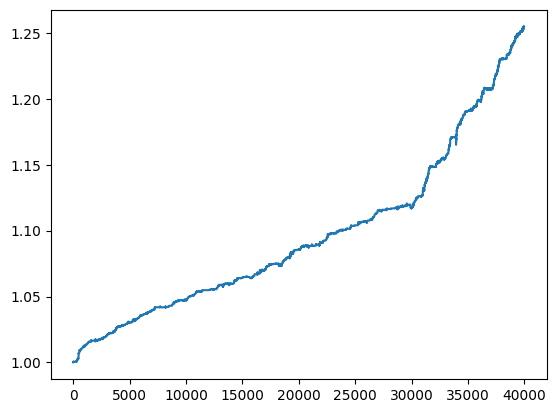

In [94]:
strategy = FutureLookupStrategy(timestamps, bids, asks)
final_cash = strategy.run()

# Equity curve
mark_to_market = [
    pos * bid + cash
    for pos, bid, cash in zip(strategy.positions, strategy.bid, strategy.cash_history)
]
weights = [
    (pos * bid) / (pos * bid + cash)
    for pos, bid, cash in zip(strategy.positions, strategy.bid, strategy.cash_history)
]

pd.Series(mark_to_market).plot()

print(
    f"""
        Final cash value of portfolio {mark_to_market[-1]:.2f}\n
        Starting number of instruments held {list(filter(lambda x: x != 0, strategy.positions))[0]}\n
        Final number of instruments held {list(filter(lambda x: x != 0, strategy.positions))[-1]}
        
    """
)


## Calculate trading stats

In [ ]:
returns = pd.Series(mark_to_market).pct_change()
weights = pd.Series(weights)

#### Calculate all stats

- Returns are annualized assume no cumulative reinvestment
- Turnover is in billions of times (frequently oscilate between 0 and ~100% weight in single instrument)
- Hitrate is odd to be below 50% but also assuming we're setting weight to 0% a lot - quite reasonable to have 0% returns frequently
- Sharpe, sortino and calmar are incredibly high as expected for biased strategy

In [104]:
sum_return = np.nansum(returns)
total_periods = compute_effective_period_count(timestamps, target_period_length='1s')
annualization = estimate_annualization_factor_unix(timestamps)

ann_r = annualized_returns_linear(sum_return, total_periods, annualization)

stats = {
    "Annualized return (linear)": ann_r,
    "Annualized turnover (billion times)": annualized_turnover(
        np.nansum(np.abs(weights)),
        total_periods,
        freq=None,
        annualization_factor=annualization
    ) / 1e9,
    "Max drawdown": max_drawdown(returns.fillna(0.0)),
    "Hit rate": hit_rate(returns),
    "Portfolio efficiency": naive_portfolio_efficiency(
        returns,
        weights,
        timestamps=timestamps
    ),
    "Annualized Sharpe": annualized_sharpe(
        returns, 
        annualization_factor=annualization
    ),
    "Sortino ratio": sortino_ratio(
        returns.fillna(0.0), 
        annualization_factor=annualization
    ),
    "Calmar ratio": calmar_ratio(
        returns.fillna(0.0), 
        annualization_factor=annualization,
        timestamps=timestamps
    ),
}

stats = {k: float(v) for k, v in stats.items()}



#### Stats are obviously abnormal - strategy allows for "perfectly informed environment"

In [110]:
stats

{'Annualized return (linear)': 22115.60644696931,
 'Annualized turnover (billion times)': 1.8893066468785364,
 'Max drawdown': 0.005904089264369079,
 'Hit rate': 0.13902231562093464,
 'Portfolio efficiency': 1.1393969108547042,
 'Annualized Sharpe': 1256.704938217669,
 'Sortino ratio': 1881.2062759474718,
 'Calmar ratio': 93.71088928685633}